In [1]:
''' plot SD & model's bandpass velocity for HU Lee's case '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from mystats import bandpass
from values_to_colors import values_to_rgba, truncate_colormap
from convert_time import datetime_to_yearday
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [34]:
''' Model Wind power data file info '''
year = '2023'
n_f = [0.8,1.2]
lonlim = np.array([-80, -40])
latlim = np.array([10, 45])
tlim = [datetime.datetime(int(year),9,4), datetime.datetime(int(year),9,21)]
tlim_str = tlim[0].strftime('%Y%m%d')+'-'+tlim[1].strftime('%Y%m%d')
xylim_str = '{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])
path_model = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/compute_wp/')
fn_data = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV({:.2f}f-{:.2f}f)_'.format(n_f[0],n_f[1])+tlim_str+'_'+xylim_str+'.nc'
''' Read data '''
ds_model = nc.Dataset(path_model + fn_data)
print(ds_model)
''' Read variables '''
vars_str = ['time','latitude','longitude','UFLX_AVE','VFLX_AVE','u_bp','v_bp']
for i, var_str in enumerate( vars_str ):
    str_exec = var_str + '= ds_model.variables["'+ var_str +'"][:]'
    exec(str_exec)
dtime_model = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) for dt in time])
longitude_model = longitude
latitude_model = latitude
u_bp_model = u_bp*100 # cm/s
v_bp_model = v_bp*100
UFLX_AVE_model = UFLX_AVE
VFLX_AVE_model = VFLX_AVE
del longitude, latitude, u_bp, v_bp, UFLX_AVE, VFLX_AVE
ds_model.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
    subtitle: It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(432), longitude(500), latitude(506)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 u_bp(time, latitude, longitude), float64 v_bp(time, latitude, longitude)
    groups: 


In [3]:
''' Load SD position & wind power data info '''
path_SD = os.getcwd()
fnpos_all = np.sort( os.listdir(path_SD) )
### retain the fnpos wanted only
fnpos = np.array([])
for file in fnpos_all:
    if ('wp_energy' in file) & ('.txt' in file):
        fnpos = np.append(fnpos, file)
print(len(fnpos),'Files have "wp_energy" & ".txt" in the',path_SD)
print(fnpos)

3 Files have "wp_energy" & ".txt" in the /Users/chi/Documents/projects/sd-ni-wp/HU_LEE
['timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1036_20230907-0919_600.0-sec-grid.txt'
 'timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1041_20230906-0918_600.0-sec-grid.txt'
 'timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1069_20230903-0915_600.0-sec-grid.txt']


SD-1036
SD-1041
SD-1069


<Figure size 432x288 with 0 Axes>

<Figure size 1512x360 with 0 Axes>

<Figure size 1512x360 with 0 Axes>

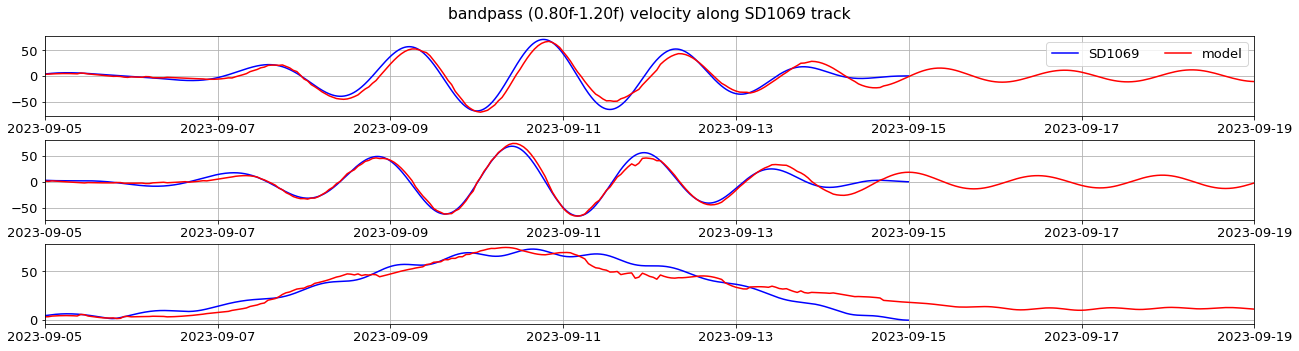

In [33]:
''' compare time series of plot SD's bandpass velocity with model's '''
dtime_plot = [datetime.datetime(int(year),9,5), datetime.datetime(int(year),9,19)]
''' plot settings '''
nrow = 3; ncol = 1
ubp_SDs_in_model = []
vbp_SDs_in_model = []
platf_num_SD = []
for i, file in enumerate( fnpos ):
    dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
    ''' find the platf number of this SD '''
    id = file.find('-SD')
    platf_num_SD.append(file[id+3:id+7])
    dtime_this_SD = np.array( [datetime.datetime.fromtimestamp(dataSD[i,0]) for i in range(dataSD.shape[0])] )
    itSD = np.where( (dtime_this_SD>= dtime_plot[0]) & (dtime_this_SD< dtime_plot[1]) )[0]
    if len(itSD) == 0:
        print('No SD-'+platf_num_SD[-1],' data for',dtime_plot[0],'-',dtime_plot[1])
    else:
        print('SD-'+platf_num_SD[-1])
        ''' find collocated model values following SD '''
        ubp_this_model = []
        vbp_this_model = []
        for t, dtime in enumerate( dtime_model ):
            ### find the corresponding time in dataSD
            irow_dataSD = np.argmin( np.abs(dtime_this_SD-dtime) )
            lon_irow_dataSD = dataSD[irow_dataSD, 1]
            lat_irow_dataSD = dataSD[irow_dataSD, 2]
            ilon_model = np.argmin( np.abs(longitude_model-lon_irow_dataSD) )
            ilat_model = np.argmin( np.abs(latitude_model-lat_irow_dataSD) )
            ubp_this_model.append( u_bp_model[t,ilat_model,ilon_model] )
            vbp_this_model.append( v_bp_model[t,ilat_model,ilon_model] )
        ubp_SDs_in_model.append( ubp_this_model )
        vbp_SDs_in_model.append( vbp_this_model )
        
        ''' plot bandpass velocity '''
        plt.clf()
        plt.rcParams.update({'font.size': 13})
        fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
        plt.gcf().set_size_inches(21, 5)
        ''' u_bp '''
        plt.subplot(nrow,ncol,1)
        plt.plot(dtime_this_SD, dataSD[:,7],color='b',label='SD'+platf_num_SD[-1])
        plt.plot(dtime_model, ubp_this_model,color='r',label='model')
        ''' v_bp '''
        plt.subplot(nrow,ncol,2)
        plt.plot(dtime_this_SD, dataSD[:,8],color='b')
        plt.plot(dtime_model, vbp_this_model,color='r')
        ''' total bp vel. '''
        plt.subplot(nrow,ncol,3)
        test = np.sqrt( np.square(dataSD[:,7]) + np.square(dataSD[:,8]) )
        plt.plot(dtime_this_SD, test,color='b')
        test = np.sqrt( np.square(ubp_this_model) + np.square(vbp_this_model) )
        plt.plot(dtime_model, test, color='r')
        for p in range(nrow):
            plt.subplot(nrow,ncol,p+1)
            plt.xlim(dtime_plot)
            plt.grid()
            if p == 0:
                plt.legend(ncol=2,loc='best')
        ''' save figure '''
        plt.suptitle('bandpass ({:.2f}f-{:.2f}f) velocity along SD'.format(n_f[0],n_f[1])+platf_num_SD[-1]+' track')
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.3)
        plt.savefig('timeseries_bp({:.2f}f-{:.2f}f)_vel_model_SD'.format(n_f[0],n_f[1])+platf_num_SD[-1]+'.png',dpi=400,bbox_inches='tight')
        # break

SD-1036
SD-1041
SD-1069


<Figure size 432x288 with 0 Axes>

<Figure size 1512x360 with 0 Axes>

<Figure size 1512x360 with 0 Axes>

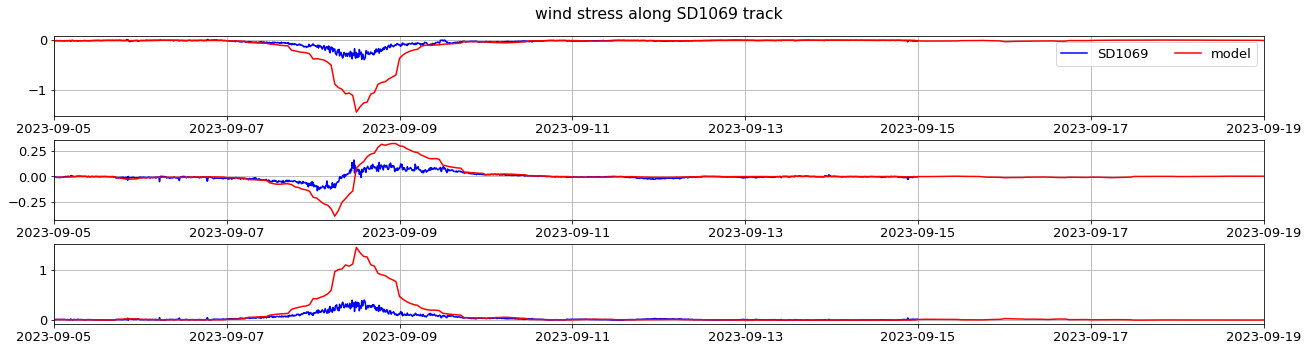

In [39]:
''' compare time series of plot SD's wind stress with model's '''
dtime_plot = [datetime.datetime(int(year),9,5), datetime.datetime(int(year),9,19)]
''' plot settings '''
nrow = 3; ncol = 1
taux_SDs_in_model = []
tauy_SDs_in_model = []
dtime_SDs_in_model = []
platf_num_SD = []
for i, file in enumerate( fnpos ):
    dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
    ''' find the platf number of this SD '''
    id = file.find('-SD')
    platf_num_SD.append(file[id+3:id+7])
    dtime_this_SD = np.array( [datetime.datetime.fromtimestamp(dataSD[i,0]) for i in range(dataSD.shape[0])] )
    itSD = np.where( (dtime_this_SD>= dtime_plot[0]) & (dtime_this_SD< dtime_plot[1]) )[0]
    if len(itSD) == 0:
        print('No SD-'+platf_num_SD[-1],' data for',dtime_plot[0],'-',dtime_plot[1])
    else:
        print('SD-'+platf_num_SD[-1])
        ''' find collocated model values following SD '''
        taux_this_model = []
        tauy_this_model = []
        dtime_this_model = []
        for t, dtime in enumerate( dtime_model ):
            ### find the corresponding time in dataSD
            irow_dataSD = np.argmin( np.abs(dtime_this_SD-dtime) )
            lon_irow_dataSD = dataSD[irow_dataSD, 1]
            lat_irow_dataSD = dataSD[irow_dataSD, 2]
            ilon_model = np.argmin( np.abs(longitude_model-lon_irow_dataSD) )
            ilat_model = np.argmin( np.abs(latitude_model-lat_irow_dataSD) )
            taux_this_model.append( -UFLX_AVE_model[t,ilat_model,ilon_model] )
            tauy_this_model.append( -VFLX_AVE_model[t,ilat_model,ilon_model] )
            dtime_this_model.append( dtime )
        taux_SDs_in_model.append( taux_this_model )
        tauy_SDs_in_model.append( tauy_this_model )
        dtime_SDs_in_model.append( dtime_this_model )
        ''' plot bandpass velocity '''
        plt.clf()
        plt.rcParams.update({'font.size': 13})
        fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
        plt.gcf().set_size_inches(21, 5)
        ''' u_bp '''
        plt.subplot(nrow,ncol,1)
        plt.plot(dtime_this_SD, dataSD[:,3],color='b',label='SD'+platf_num_SD[-1])
        plt.plot(dtime_model, taux_this_model,color='r',label='model')
        ''' v_bp '''
        plt.subplot(nrow,ncol,2)
        plt.plot(dtime_this_SD, dataSD[:,4],color='b')
        plt.plot(dtime_model, tauy_this_model,color='r')
        ''' total bp vel. '''
        plt.subplot(nrow,ncol,3)
        test = np.sqrt( np.square(dataSD[:,3]) + np.square(dataSD[:,4]) )
        plt.plot(dtime_this_SD, test,color='b')
        test = np.sqrt( np.square(taux_this_model) + np.square(tauy_this_model) )
        plt.plot(dtime_model, test, color='r')
        for p in range(nrow):
            plt.subplot(nrow,ncol,p+1)
            plt.xlim(dtime_plot)
            plt.grid()
            if p == 0:
                plt.legend(ncol=2,loc='best')
        ''' save figure '''
        plt.suptitle('wind stress along SD'+platf_num_SD[-1]+' track')
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.3)
        plt.savefig('timeseries_windstress_model_SD'+platf_num_SD[-1]+'.png',dpi=400,bbox_inches='tight')
        # break

SD-1036
SD-1041
SD-1069


<Figure size 432x288 with 0 Axes>

<Figure size 1512x252 with 0 Axes>

<Figure size 1512x252 with 0 Axes>

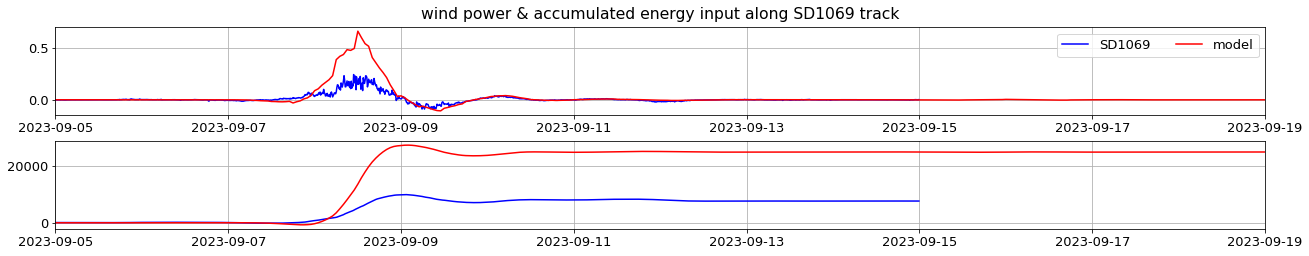

In [45]:
''' compute wind power & accumulated energy along SD tracks '''
dtime_plot = [datetime.datetime(int(year),9,5), datetime.datetime(int(year),9,19)]
''' plot settings '''
nrow = 2; ncol = 1
wp_SDs_in_model = []
energy_SDs_in_model = []
platf_num_SD = []
for i, file in enumerate( fnpos ):
    dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
    ''' find the platf number of this SD '''
    id = file.find('-SD')
    platf_num_SD.append(file[id+3:id+7])
    dtime_this_SD = np.array( [datetime.datetime.fromtimestamp(dataSD[i,0]) for i in range(dataSD.shape[0])] )
    itSD = np.where( (dtime_this_SD>= dtime_plot[0]) & (dtime_this_SD< dtime_plot[1]) )[0]
    if len(itSD) == 0:
        print('No SD-'+platf_num_SD[-1],' data for',dtime_plot[0],'-',dtime_plot[1])
    else:
        print('SD-'+platf_num_SD[-1])
        ''' compute wind power & accumulated energy following SD '''
        dtime_this_model = dtime_SDs_in_model[i]
        timestamp_this_model = np.array([dtime.timestamp() for t, dtime in enumerate(dtime_this_model)])
        wp_this_model = np.multiply( np.array(taux_SDs_in_model[i]),0.01*np.array(ubp_SDs_in_model[i])) + \
            np.multiply( np.array(tauy_SDs_in_model[i]),0.01*np.array(vbp_SDs_in_model[i]) )
        energy_input_this_model = np.nan*np.ones( (len(timestamp_this_model),) )
        for t in range( len(timestamp_this_model) ):
            nan_mask = ~np.isnan( wp_this_model )
            y_clean = wp_this_model[nan_mask]
            x_clean = timestamp_this_model[nan_mask]
            energy_input_this_model[t] = np.trapz(y_clean[:t],x_clean[:t])
        wp_SDs_in_model.append( wp_this_model )
        energy_SDs_in_model.append( energy_input_this_model )

        ''' plot '''
        plt.clf()
        plt.rcParams.update({'font.size': 13})
        fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
        plt.gcf().set_size_inches(21, 3.5)
        ''' wind power (W/m^2) '''
        plt.subplot(nrow,ncol,1)
        plt.plot(dtime_this_SD, dataSD[:,9],color='b',label='SD'+platf_num_SD[-1])
        plt.plot(dtime_this_model, wp_this_model, color='r',label='model')
        ''' energy input (J/m^2) '''
        plt.subplot(nrow,ncol,2)
        plt.plot(dtime_this_SD, dataSD[:,10],color='b')
        plt.plot(dtime_this_model, energy_input_this_model, color='r')
        for p in range(nrow):
            plt.subplot(nrow,ncol,p+1)
            plt.xlim(dtime_plot)
            plt.grid()
            if p == 0:
                plt.legend(ncol=2,loc='best')
        ''' save figure '''
        plt.suptitle('wind power & accumulated energy input along SD'+platf_num_SD[-1]+' track')
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.3)
        plt.savefig('timeseries_wp_energy_model_SD'+platf_num_SD[-1]+'.png',dpi=400,bbox_inches='tight')
        # break